# Lab One: CNN Visualization

### name of programmer: Bochuan Wu  
### SMU ID : 47497181

# 1.Answer for why we use DeepDream to analyze a CNN visually:

We know that the neural network has made remarkable result in image classification, but the number of parameters in the deep learning network is huge, and the algorithm is considered as a black box. Although it can achieve good results, we still know little about it's interior.   
So we need those kind of tool that can look into the interior of the network and see how the network distinguishes images and how does images present inside the model.   
DeepDream is a good way that can show each layer's output, we can find out what model may think to an input image.  

for example,in the blog post by professor, the network classify dumbbells, so if we train a network can only classify dumbbells, it may 'dream' everything to be dumbbells. But the output of layer shows that there is a muscular weightlifter, that maybe means that the dataset we provided for dumbbells contain a muscular weightlifter, we need to find more data that only have dumbbells.


# 2.select a convolutional neural network model:

### reason for choose this model: Residual networks（resnet）

Resnet(Residual networks) is a great CNN model comparing to other exsisting model.  
the reason why i choose Resnet50 is following：  
1. Before Resnet, the deepest neural network is only googleNet with 22 layers, and the Resnet can reach 100 even 1000  
2. Generally, the deeper layer a model reach, the more information from model can be discovered  
3. The tradition method of neural network learning is using Batch Normalization and normalized initialization to solve gradient explosion problem and gradient disappearance problem(like Figure1), but when layer number raise really high, it's result goes worse, because the ability of network is degenerated. The Resnet gives a new block which can solve this problem(like Figure2). 

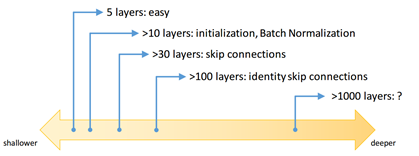

                                                                Figure1

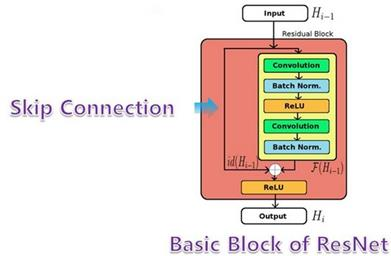

                                                                Figure2

#  3.load the model and show:

In [2]:
from keras.applications.resnet50 import ResNet50

In [3]:
res=ResNet50(include_top=False,weights='imagenet')

C:\tool\python\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [49]:
res.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

# 4.Visualizing the Activation of a Channel

(1, 224, 224, 3)


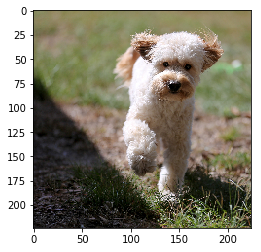

In [33]:
#using the same image as lecture
img_url = 'https://raw.githubusercontent.com/8000net/LectureNotes/master/images/dog.jpg'
from keras.preprocessing import image
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import cv2

def load_image_as_array(url, size=(224, 224)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    #resize the image to the shape that model needs
    img = img.resize(size)
    return np.array(img).astype(float)

img_tensor = load_image_as_array(img_url)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.


print(img_tensor.shape)

import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [4]:
from keras import models
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in res.layers[-2::]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=res.input, outputs=layer_outputs)

In [5]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 7, 7, 2048)


from the lecture note we already know that the front-level layers' output,  
so i will show the later-level layers' output and find out if there is any high-level abstract concepts

C:\tool\python\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


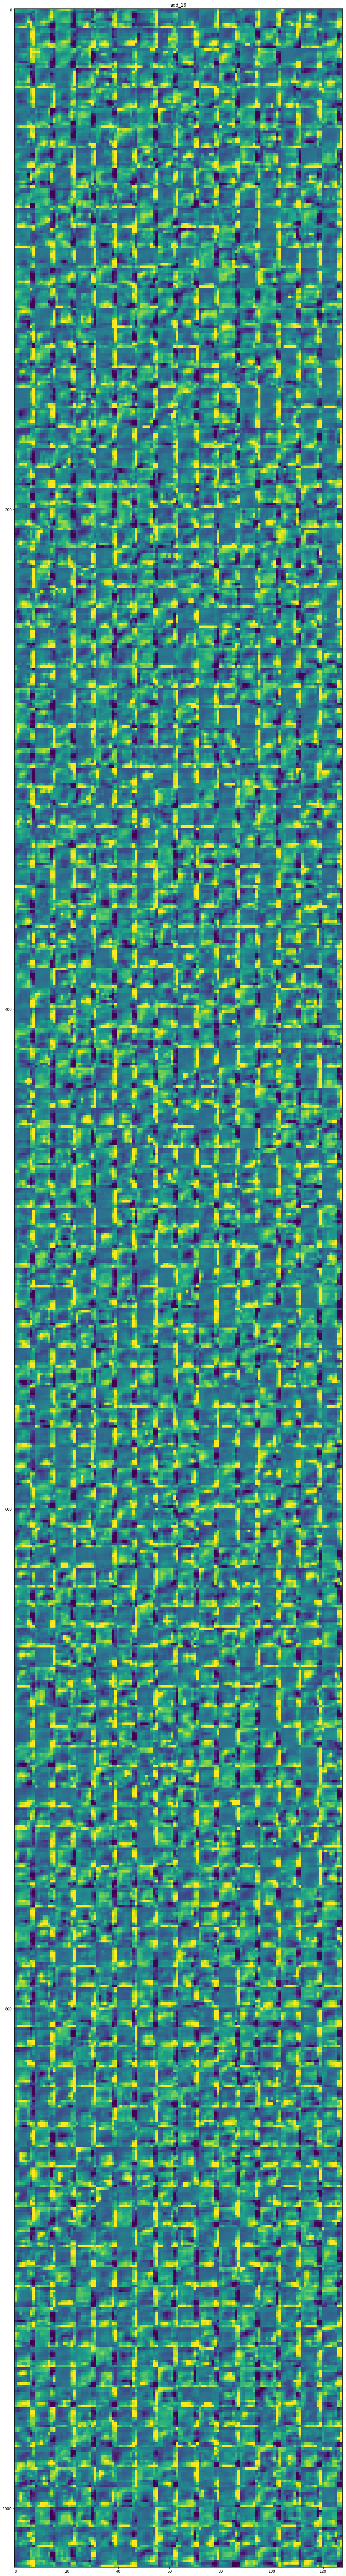

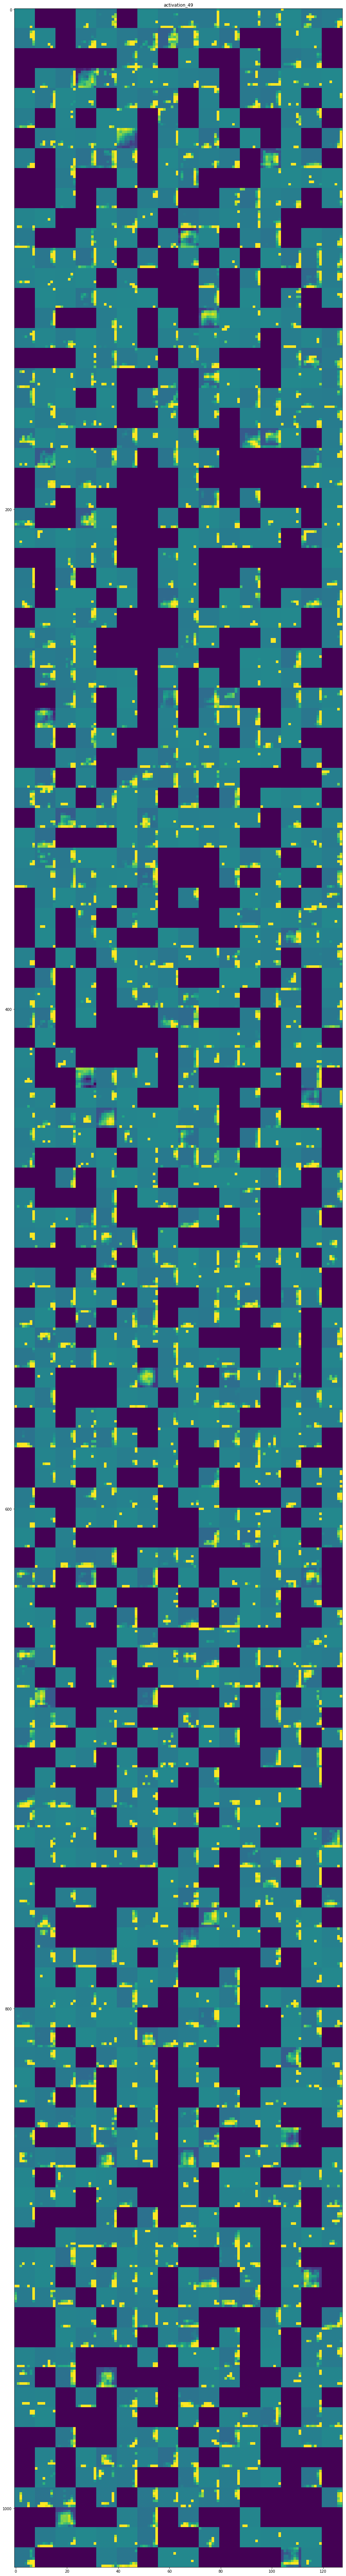

In [19]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in res.layers[-2::]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

for the Resnet model, it is really a deep network that the high level feature becomes abstract concept, and the feature map shows that many of filter doesn't work for this image.

# 5.Using L1 gradient normalization for gradient updates

║x║p=(|x1|^p+|x2|^p+...+|xn|^p)

L1 norm is the sum of absolute value

In [17]:
from keras import backend as K
# Selecting a layer and channel to visualize
layer_name = 'res4c_branch2a'
filter_index = 0
 
# Isolate the output and loss for the given chanel
layer_output = res.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# We take the gradient of this loss using keras backend.gradients
grads = K.gradients(loss, res.input)[0]

# Before performing gradient descent, we divide the gradient tensor by its L1 norm 
grads /= (K.mean(K.abs(grads)) + 1e-5)

# We use a keras backend function to accept a numpy tensor and return a loss and gradient for that tensor.
iterate = K.function([res.input], [loss, grads])

# To quickly test the interface:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 224, 224, 3))])

# 6.Visualizing a Single Filter

In [16]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [44]:
import cv2
def generate_pattern(layer_name, filter_index, size=224):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = res.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, res.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.mean(K.abs(grads)) + 1e-5)


    # This function returns the loss and grads given the input picture
    iterate = K.function([res.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    #creat the vedio process
    fps = 1  
    size = (224,224) 
    videowriter = cv2.VideoWriter("a.avi",cv2.VideoWriter_fourcc('M','J','P','G'),fps,size)

    

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        image = input_img_data[0]
        videowriter.write(image)
    img = input_img_data[0]
    return deprocess_image(img)

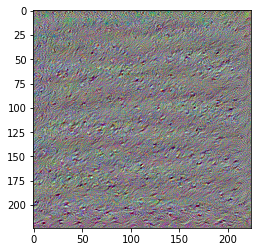

In [47]:
plt.imshow(generate_pattern('res4c_branch2a', 7))
plt.show()

the 40 iterate result for this single filter can be find in the video named 'a.avi'

# 7.Adding random shifts/resizing in the process

If we keep using the original image in the process of deepdream, the convergence rate may be slow, so we first reduce the image to update, and then zoom in to update.

Max_jitter is an integer representing the range of jitter. Two integers are randomly extracted to indicate the degree of jitter on the x-axis and y-axis.  
np.roll is used to translate the array along a dimension. The following code first translates the third dimension of the picture to shift_x, and then translates the second dimension to shift_y.

In [59]:
from keras.preprocessing import image
def preprocess_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224,224))
    img = image.img_to_array(img) #convert to array
    img = np.expand_dims(img, axis=0) # add batch dimensions
    img = preprocess_input(img) # preprocessing
    return img

def resize_img(img, size):
    img = np.copy(img)
  #ratios to multiply to image dimensions to resize
    factors = (1,
             float(size[0]/img.shape[1]),
             float(size[1]/img.shape[2]),
             1                
            )
  #applying ratios using scipy
    return  scipy.ndimage.zoom(img, factors, order=1)

def deprocess_image(x):
    x = x.reshape((x.shape[1], x.shape[2], 3)) #reshaping to ( h,w,c )
    #deprocess
    x /= 2. 
    x += 0.5
    x *= 255.
    
    #clipping value out if range ( 0,255 ) ie out RGB value range
    x = np.clip(x, 0, 255).astype('uint8')
    return x
#random shifts
'''
max_jitter = 32
shift_x, shift_y = np.random.randint(-max_jitter, max_jitter + 1, 2)
img = np.roll(np.roll(img, shift_x, -1), shift_y, -2)
'''

'\nmax_jitter = 32\nshift_x, shift_y = np.random.randint(-max_jitter, max_jitter + 1, 2)\nimg = np.roll(np.roll(img, shift_x, -1), shift_y, -2)\n'

another simple way to add resizing and random shifts is to use skimage liberary.

In [51]:
from skimage.transform import pyramid_gaussian, rescale

# 8.Get the deepdream result with additional noise type

In [51]:

import warnings
warnings.filterwarnings('ignore')
from keras.applications import resnet50
from keras.applications.inception_v3  import preprocess_input
from keras import backend as K
from keras.preprocessing import image
import tensorflow as tf 

from sklearn.datasets import load_sample_image
img = load_sample_image('flower.jpg')
# using resize_img to zoom the image
def resize_img(img, size):
    img = np.copy(img)
    factors = (1, float(size[0]) / img.shape[1], float(size[1]) / img.shape[2], 1)
    return scipy.ndimage.zoom(img, factors, order=1)
#define a function to store image
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    sp.misc.imsave(fname, pil_img)
#in order to get the input tensor for Resnet
def preprocess_image(img):
   # img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img
#to deprocess image
def deprocess_image(x):
    
    x = x.reshape((x.shape[1], x.shape[2], 3))
    
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype("uint8")
    return x

For this deepdream process with additional noise type , i use three layers outputs to gain a loss function rather than one, and define a combine function with coefficient.

In [ ]:
import scipy
import numpy as np
import cv2
step = 0.01
num_octave = 4
octave_scale = 1.4
iterations = 30
result_fname = 'result_deepdream.jpg'
max_jitter=32

with tf.Session() as sess:
# load the pre-trained model
    model = resnet50.ResNet50(include_top=False, weights='imagenet')
    K.set_learning_phase(0)
    layer_contributions = {
    'res5c_branch2a': 3.,
    'res5c_branch2b':2.,
    'res5c_branch2c':1.5,
    }
#build loss function for the three layer i choose and define the coefficient
    loss = K.variable(0.)

    for layer_name in layer_contributions:

        coeff = layer_contributions[layer_name]
        x = model.get_layer(name=layer_name).output
        scaling = K.prod(K.cast(K.shape(x), 'float32'))
        
        loss = loss + coeff * K.sum(K.square(x[:, 2:-2, 2:-2, :])) / scaling

    dream = model.input
#same as leacture notebook but with l1 norm
    grads = K.gradients(loss, dream)[0]
    grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
    outputs = [loss, grads]
    fetch_loss_and_grads = K.Function([dream], outputs)
# get loss value and grads value
    def eval_loss_and_grads(x):
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1]
        return loss_value, grad_values
#to calculate gradient ascent and update
    def gradient_ascent(x, iterations, step, count):
     
        for i in range(iterations):
            #random shifting
            shift_x, shift_y = np.random.randint(-max_jitter, max_jitter + 1, 2)
            x = np.roll(np.roll(x, shift_x, -1), shift_y, -2)
            loss_value, grad_values = eval_loss_and_grads(x)
            x += step * grad_values
            #reverse shifting
            x = np.roll(np.roll(x, -shift_x, -1), -shift_y, -2)
        return x


    img = preprocess_image(img)

    original_shape = img.shape[1:3]
    successive_shapes = [original_shape]
# to resize and zoom image for 4 times in order to get a good result for deepdream
    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale**i)) for dim in original_shape])
        successive_shapes.append(shape)

    successive_shapes = successive_shapes[::-1] 

    original_img = np.copy(img)
    shrunk_original_img = resize_img(img, successive_shapes[0]) # starting from smallest image
#do the loop for each resized images(4 times)    
    count=0
    for shape in successive_shapes:
        print('Processing image shape', shape)
        img = resize_img(img, shape)
        img = gradient_ascent(img, iterations=iterations, step=step ,count=count)
        upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
        same_size_original = resize_img(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img
        img += lost_detail
        shrunk_original_img = resize_img(original_img, shape)
        count+=1
        cv2.imwrite('./output/{}{}.jpg'.format(count,i),deprocess_image(img))       
    image.save_img('result_deepdream.png', deprocess_image(np.copy(img)))

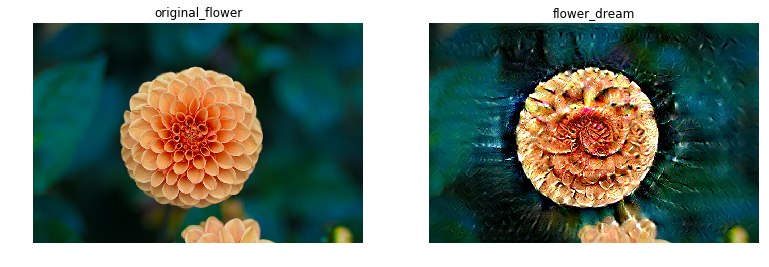

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 13))

ax1.imshow(deprocess_image(original_img))
ax1.set_axis_off()
ax1.set_title("original_flower")

ax2.imshow(deprocess_image(np.copy(img)))
ax2.set_axis_off()
ax2.set_title("flower_dream")
plt.show()

# 9.iterative process gives for how the CNN discerns different classes

From the iterative process of deepdream, firstly the output image only contain some meaningless edges and lines, after many iterations, there is object begin to generate at the output image. the deepdream method begin to let network 'dream' what the input image is. In other words，discern the input image to pre-trained class.

# 10.Without using other noise type

In [21]:

import warnings
warnings.filterwarnings('ignore')
from keras.applications import resnet50
from keras.applications.inception_v3  import preprocess_input
from keras import backend as K
from keras.preprocessing import image
import tensorflow as tf 

from sklearn.datasets import load_sample_image
img = load_sample_image('flower.jpg')
# using resize_img to zoom the image
def resize_img(img, size):
    img = np.copy(img)
    factors = (1, float(size[0]) / img.shape[1], float(size[1]) / img.shape[2], 1)
    return scipy.ndimage.zoom(img, factors, order=1)
#define a function to store image
def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    sp.misc.imsave(fname, pil_img)
#in order to get the input tensor for Resnet
def preprocess_image(img):
   # img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img
#to deprocess image
def deprocess_image(x):
    
    x = x.reshape((x.shape[1], x.shape[2], 3))
    
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [26]:
import scipy
import numpy as np
step = 0.01
num_octave = 4
octave_scale = 1.4
iterations = 30
result_fname = 'result_deepdream.jpg'
max_jitter=32
blend=0.2
with tf.Session() as sess:
# load the pre-trained model
    model = resnet50.ResNet50(include_top=False, weights='imagenet')
    K.set_learning_phase(0)
 
    layer_output = model.get_layer('res5c_branch2c').output
    loss = K.mean(layer_output[:, :, :, 7])

    dream = model.input
#same as leacture notebook but with l1 norm
    grads = K.gradients(loss, dream)[0]
    grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
    outputs = [loss, grads]
    fetch_loss_and_grads = K.Function([dream], outputs)
# get loss value and grads value
    def eval_loss_and_grads(x):
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1]
        return loss_value, grad_values
#to calculate gradient ascent and update
    def gradient_ascent(x, iterations, step, count):
 
     
        for i in range(iterations):
            #random shifting
            shift_x, shift_y = np.random.randint(-max_jitter, max_jitter + 1, 2)
            x = np.roll(np.roll(x, shift_x, -1), shift_y, -2)
            loss_value, grad_values= eval_loss_and_grads(x)
            x += step * grad_values
            #reverse shifting
            x = np.roll(np.roll(x, -shift_x, -1), -shift_y, -2)
        return x


    img = preprocess_image(img)

    original_shape = img.shape[1:3]
    successive_shapes = [original_shape]
# to resize and zoom image for 4 times in order to get a good result for deepdream
    for i in range(1, num_octave):
        shape = tuple([int(dim / (octave_scale**i)) for dim in original_shape])
        successive_shapes.append(shape)

    successive_shapes = successive_shapes[::-1] 

    original_img = np.copy(img)
    shrunk_original_img = resize_img(img, successive_shapes[0]) # starting from smallest image
#do the loop for each resized images(4 times)    
    count=0
    for shape in successive_shapes:
        print('Processing image shape', shape)
        img = resize_img(img, shape)
        img = gradient_ascent(img, iterations=iterations, step=step ,count=count)
        upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
        same_size_original = resize_img(original_img, shape)
        lost_detail = same_size_original - upscaled_shrunk_original_img
       
        #Blend the original and processed images with ratio
        img += lost_detail
        
        shrunk_original_img = resize_img(original_img, shape)
        count+=1
        
    image.save_img('result_deepdream.png', deprocess_image(np.copy(img)))

Processing image shape (155, 233)
Processing image shape (217, 326)
Processing image shape (305, 457)
Processing image shape (427, 640)


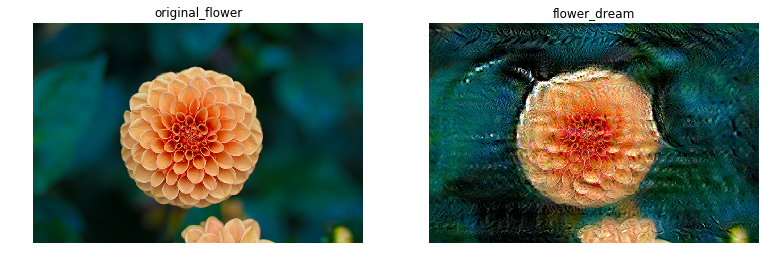

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline 
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 13))

ax1.imshow(deprocess_image(original_img))
ax1.set_axis_off()
ax1.set_title("original_flower")

ax2.imshow(deprocess_image(np.copy(img)))
ax2.set_axis_off()
ax2.set_title("flower_dream")
plt.show()

the deepdream process with and without additional noise will creat different object on the original image.

# 11.Get the predictions of the input image with top 3(for image dallas_hall)

In [6]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
model = ResNet50(weights='imagenet')
img_url = 'https://raw.githubusercontent.com/8000net/LectureNotes/master/images/dallas_hall.jpg'
img = load_image_as_array(img_url, size=(224, 224))
x = np.expand_dims(img, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])


Predicted: [('n03220513', 'dome', 0.70021588), ('n03956157', 'planetarium', 0.17851256), ('n03788195', 'mosque', 0.098929644)]


the result is wrong but understandable.

# 12.Get heat map

In [8]:
from keras import backend as K
predicted_class = np.argmax(preds)
predicted_class_output = model.output[:, predicted_class]

# The is the output feature map of the `res5c_branch2c` layer,
# the last convolutional layer in ResNet50
last_conv_layer = model.get_layer('res5c_branch2c')

# This is the gradient of the predicted class with regard to
# the output feature map of `res5c_branch2c`
grads = K.gradients(predicted_class_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `res5c_branch2c`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the predicted class
for i in range(2048):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

# We then normalize the heatmap 0-1 for visualization:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [16]:
import cv2

# We use cv2 to load the original image
img = cv2.imread("dallas_hall.jpg")

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./dallas_hall_palace_heatmap.jpg', superimposed_img)


True

Dallas Hall  dome Activation

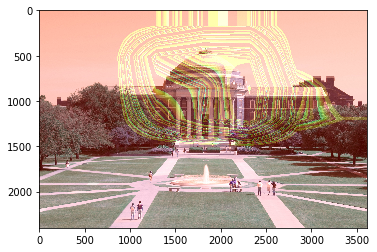

In [39]:
%matplotlib inline 
import cv2
img=cv2.imread('dallas_hall_palace_heatmap.jpg')
plt.imshow(img)
plt.show('img')

# 13.live demo of heatmap by lecture note

In [21]:
import keras
from keras.models import load_model
from keras import backend as K
from keras.preprocessing import image
import numpy as np
import requests
from io import BytesIO
from PIL import Image
from keras import models
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
import cv2

import copy

video_stream = cv2.VideoCapture(0)
video_stream.set(3,224)
video_stream.set(4,224)

model = ResNet50(weights='imagenet')


while(True):
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    ret, img_original = video_stream.read()

    frame_down = cv2.resize(img_original, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

    # increase contrast
    img_yuv = cv2.cvtColor(frame_down, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])# equalize the histogram of the Y channel
    frame_down = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)# convert the YUV image back to RGB format

    # and then remove noise
    frame_down = cv2.fastNlMeansDenoisingColored(frame_down,None,7,7,3,11)

    img = frame_down.copy() # make a copy for numpy

    img = image.img_to_array(img[:,:,::-1]) # convert to numpy


    img_original = cv2.resize(img_original, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    x = np.expand_dims(img, axis=0)

    # Finally we preprocess the batch
    # (this does channel-wise color normalization)
    x = preprocess_input(x)

    preds = model.predict(x)
    text = str(decode_predictions(preds, top=1)[0])
    print('Predicted:', text)

    predicted_class = np.argmax(preds)

    predicted_class_output = model.output[:, predicted_class]

    # The is the output feature map of the `block5_conv3` layer,
    # the last convolutional layer in VGG16
    last_conv_layer = model.get_layer('res5c_branch2c')

    # This is the gradient of the predicted class with regard to
    # the output feature map of `block5_conv3`
    grads = K.gradients(predicted_class_output, last_conv_layer.output)[0]

    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the predicted class
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)

    # We then normalize the heatmap 0-1 for visualization:
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    img = img_original

    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.4 + img * 0.6
    
    cv2.putText(superimposed_img, text, 
                (5, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), lineType=cv2.LINE_AA)

    cv2.imshow('frame', superimposed_img.astype(np.uint8))

Predicted: [('n02843684', 'birdhouse', 0.092958279)]


C:\tool\python\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide


Predicted: [('n04548362', 'wallet', 0.072803907)]
Predicted: [('n04548362', 'wallet', 0.060199372)]
Predicted: [('n04548362', 'wallet', 0.071993895)]
Predicted: [('n03873416', 'paddle', 0.07030911)]
Predicted: [('n04548362', 'wallet', 0.064502805)]
Predicted: [('n03873416', 'paddle', 0.064327724)]
Predicted: [('n04209239', 'shower_curtain', 0.045899034)]


# 14.Control the dream of model

In order to control the deepdream process, we need to input a picture as the control picture of dream, and then we can get the feature vector by forward propagation of the control picture through the network.  
Then we input the original picture into the network and get the feature vector. The two feature vectors are different in size. So we can rearrange them into a new matrix, then do matrix multiplication, and finally select the largest subscript in the matrix multiplication. The feature vectors of the original picture corresponding to the subscripts are extracted as new feature vectors. These feature vectors are considered to be the most matching feature vectors of the controlled picture, so that the controlled dream can be obtained.
link is following:https://github.com/L1aoXingyu/Deep-Dream/blob/master/show_image.ipynb

the most important part of code is following(no time for training model): 

In [54]:
def objective_guide(img, guide_features):
    x = img
    y = guide_features
    ch, w, h = x.shape
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    result = y[:,A.argmax(1)] # select ones that match best
    return result #using this result to match with original picture